# RPN & Analysis

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from urllib import request
from tensorflow.keras import initializers
np.set_printoptions(suppress=True)

2024-03-12 21:05:22.508993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 21:05:22.509156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 21:05:22.624570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 21:05:22.853756: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 21:05:24.580927: W tensorflow/compiler/tf2

# Declare Parameters

In [2]:
# Setup some parameters
DATA_DIR = "./data/images"

In [3]:
# Download test image
# request.urlretrieve("https://i.imgur.com/XjeiRMV.jpg", f"{DATA_DIR}/test.JPG")
# request.urlretrieve("https://i.imgur.com/XjeiRMV.jpg", "test.JPG")

# Helper Functions

In [4]:
def to_VOC_format(width, height, center_x, center_y):
    """
    Convert center coordinate format to min max coordinateformat
    """
    x_min = center_x - 0.5 * width
    y_min = center_y - 0.5 * height
    x_max = center_x + 0.5 * width
    y_max = center_y + 0.5 * height
    return x_min, y_min, x_max, y_max


def to_center_format(xmin_list, ymin_list, xmax_list, ymax_list):
    """
    Convert min max coordinate format to x_center, y_center, height and width format
    """
    height = ymax_list - ymin_list
    width = xmax_list - xmin_list
    
    center_x = xmin_list + 0.5 * width
    center_y = ymin_list + 0.5 * height
    
    return width, height, center_x, center_y


def adjust_deltas(anchor_width, anchor_height, anchor_center_x, achor_center_y, dx, dy, dw, dh):
    """
    Adjust the anchor box with predicted offset
    """
    # ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    center_x = dx * anchor_width + anchor_center_x 
    
    # ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    center_y = dy *  anchor_height + anchor_center_y
    
    # w = np.exp(dw) * anc_width[:, np.newaxis]
    width = np.exp(dw) * anchor_width
    
    # np.exp(dh) * anc_height[:, np.newaxis]
    height = np.exp(dh) * anchor_height
    
    return width, height, center_x, center_y


def compute_deltas(base_center_x, 
                base_center_y, 
                base_width, 
                base_height, 
                inside_anchor_width, 
                inside_anchor_height, 
                inside_anchor_center_x, 
                inside_anchor_center_y):
    """
    computing offset of achor box to the groud truth box
    """
    dx = (base_center_x - inside_anchor_center_x)/ inside_anchor_width  # difference in centers of ground truth and anchor box across x axis
    dy = (base_center_y - inside_anchor_center_y)/  inside_anchor_height  # difference in centers of ground truth and anchor box across y axis
    dw = np.log(base_width/ inside_anchor_width) # log on ratio between ground truth width and anchor box width
    dh = np.log(base_height/ inside_anchor_height) # log on ratio between ground truth height and anchor box height
    return dx, dy, dw, dh

(333, 500, 3)


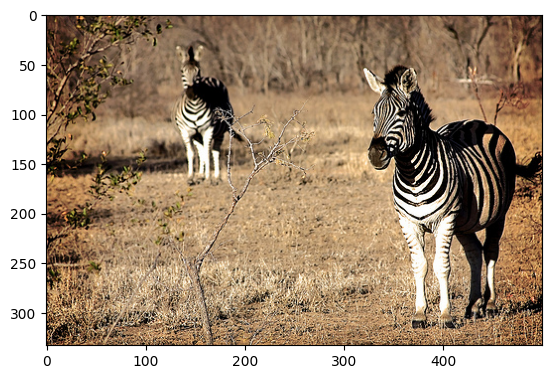

In [5]:
# load the image
img = cv2.imread(f'{DATA_DIR}/test.JPG')
# change the format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print the shape of the image
print(img.shape)
img_h, img_w, _ = img.shape
plt.imshow(img)

# Creating and Visualizing the Annotation
The image contains two objects that we want to detect, let's go ahead and draw two rectangle around the two objects.

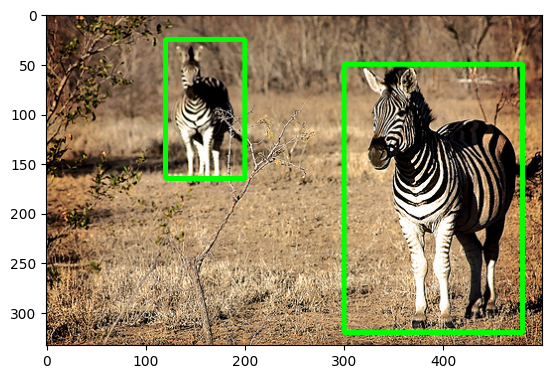

In [6]:
# creating ground truth box and labels for each ground truth
bbox_list = np.array([[120, 25, 200, 165], 
                    [300, 50, 480, 320]]) # xmin, ymax, xmax, ymin

# labels 1 for zebra, 0 for background
labels = np.array([1, 1])

# visualize the ground truth boxes
img_ = np.copy(img)
for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()

# Resizing the input image and annotations accordingly

1.6 2.4024024024024024


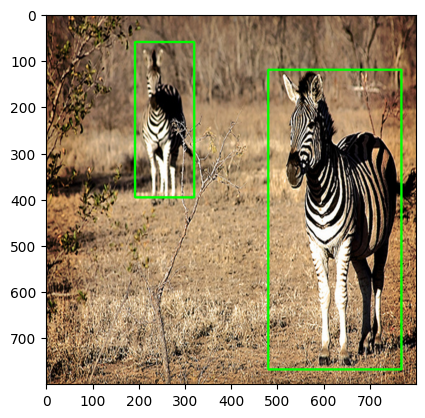

In [7]:
# resizing to 800x800
h = w = 800

# resize input to 800 x 800 (so that we could feed it to pre trained image classification model to extract features)
img = cv2.resize(img, (h,w), interpolation=cv2.INTER_CUBIC)

# resize the ground truth boxes
x_alter = w/img_w   # width alter
y_alter = h/img_h   # height alter

print(x_alter, y_alter)

bbox_list[:,0] = bbox_list[:,0]*x_alter         # alter xmin
bbox_list[:,1] = bbox_list[:,1]*y_alter         # alter ymin
bbox_list[:,2] = bbox_list[:,2]*x_alter         # alter xmax
bbox_list[:,3] = bbox_list[:,3]*y_alter         # alter ymax


# visualize the ground truth boxes
img_ = np.copy(img)
for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()

# Use pretrained VGG16 backbone network
VGG16 is pretrained for classification tasks. So the network would already learned the convolution feature map of the underlying image. Let's detach the classification layers and feed the image into the network

In [8]:
vgg = keras.applications.VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(h,w,3)
)

# clone the image
img_ = np.copy(img)[np.newaxis, ...]

# iterate through each layer and visualize the output shape
fe = vgg.layers
l = 0
for layer in fe:
    output = K.function([vgg.layers[0].input], [layer.output])
    print(output(img_)[0].shape, l)
    l +=1

2024-03-12 21:05:34.372211: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 21:05:34.372351: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 21:05:35.056511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 21:05:35.056625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 21:05:35.056688: I external/local_xla/xla/stream_executor

(1, 800, 800, 3) 0


2024-03-12 21:05:38.142281: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


(1, 800, 800, 64) 1
(1, 800, 800, 64) 2
(1, 400, 400, 64) 3
(1, 400, 400, 128) 4
(1, 400, 400, 128) 5
(1, 200, 200, 128) 6
(1, 200, 200, 256) 7
(1, 200, 200, 256) 8
(1, 200, 200, 256) 9
(1, 100, 100, 256) 10
(1, 100, 100, 512) 11
(1, 100, 100, 512) 12
(1, 100, 100, 512) 13
(1, 50, 50, 512) 14
(1, 50, 50, 512) 15
(1, 50, 50, 512) 16
(1, 50, 50, 512) 17
(1, 25, 25, 512) 18


In [9]:
# setting up the backbone network
backbone = Model(inputs = [vgg.layers[0].input], outputs = [vgg.layers[17].output])
backbone.predict(img_).shape

1/1 [==============================] - 1s 1s/step


(1, 50, 50, 512)

In [10]:
backbone.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 800, 800, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 800, 800, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 800, 800, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 400, 400, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 400, 400, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 400, 400, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 200, 200, 128)     0  

In [11]:
# examining the shape of feature map
feature_maps = backbone.predict(np.expand_dims(img, 0))
_, w_feature_map, h_feature_map, _ = feature_maps.shape


# number of posssible anchor positions
n_anchor_pos = w_feature_map * h_feature_map
feature_maps.shape, n_anchor_pos

1/1 [==============================] - 0s 34ms/step


((1, 50, 50, 512), 2500)

# Anchor Boxes
Predefined boxes having fixed size(s). We put different sizes/scale/area and ratio of these boxes to capture the objects of various shape and sizes. These anchor boxes are put on the input image pixel location given the provided stride based on the backbone network and preprocessed them to create labels for the RPN model. This is done because we need to anchor set of each pixel in feature map.

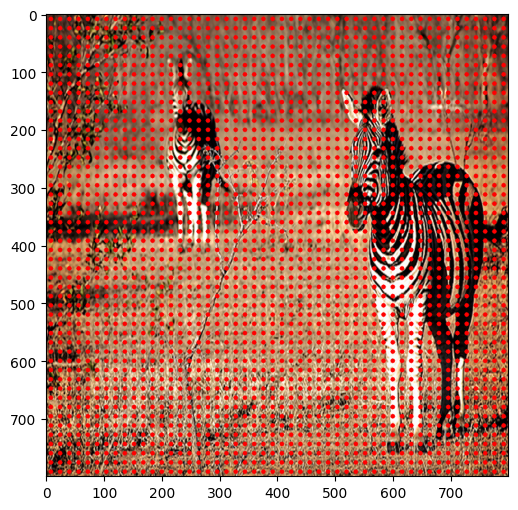

In [12]:
# generating these 2500 centers on the image, placing each of 2500 anchor location with fixed stride to match feature map shape (25*25)

# width stride on the image
x_stride = int(w / w_feature_map)
y_stride = int(h / h_feature_map)

# center (xy coordinate) of anchor location on image
x_center = np.arange(8, w, x_stride) # [  0,  32,  64,  96, 128, 160, 192,...]
y_center = np.arange(8, h, y_stride) # [  0,  32,  64,  96, 128, 160, 192,...]

# generate all the ordered pair of x and y center

# to achive this, we will use meshgrid and reshape it
center_list = np.array(np.meshgrid(x_center, y_center,  sparse=False, indexing='xy')).T.reshape(-1,2)
'''
output:
array([[  0,   0],
       [  0,  32],
       [  0,  64],
       ...,
       [768, 704],
       [768, 736],
       [768, 768]])
'''

# visualizing the anchor positions
img_ = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(n_anchor_pos):
    cv2.circle(img_, (int(center_list[i][0]), int(center_list[i][1])), radius=1, color=(255, 0, 0), thickness=5) 
plt.imshow(img_)
plt.show()

In [15]:
# generating boxes for each anchor location of different aspect ratio

al = []
# aspect ratio = width/ height
anchor_ratio_list = [0.5, 1, 2] # width is half of height(vertical rectangle), width = height (square), width is twice of height (horizontal rectangle)
anchor_scale_list = [8, 16, 32] # area of each anchor box

# total possible anchors 
n_anchors = n_anchor_pos * len(anchor_ratio_list) * len(anchor_scale_list)

# number of object in the image
n_object = len(bbox_list)

# there are total 2500 anchor centers each having 9 anchor boxes placed
# total anchor box in the feature map will be 2500 * 9 = 22500 each anchor box is denoted by 4 numbers.
anchor_list = np.zeros(shape= (n_anchors, 4))

count = 0
# to get height and width given ratio and scale, we will use formula given above
# for each anchor location
for center in center_list:
    center_x, center_y = center[0], center[1]
    # for each ratio
    for ratio in anchor_ratio_list:
        # for each scale
        for scale in anchor_scale_list:
            # compute height and width and scale them by constant factor
            h = pow(pow(scale, 2)/ ratio, 0.5)
            w = h * ratio

            # as h and w would be really small, we will scale them with some constant (in our case, stride width and height)
            h *= x_stride
            w *= y_stride


            # * at this point we have height and width of anchor and centers of anchor locations
            # putting anchor 9 boxes at each anchor locations
            anchor_xmin = center_x - 0.5 * w
            anchor_ymin = center_y - 0.5 * h
            anchor_xmax = center_x + 0.5 * w
            anchor_ymax = center_y + 0.5 * h
            al.append([center_x, center_y, w, h])
            # append the anchor box to anchor list
            anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
            count += 1

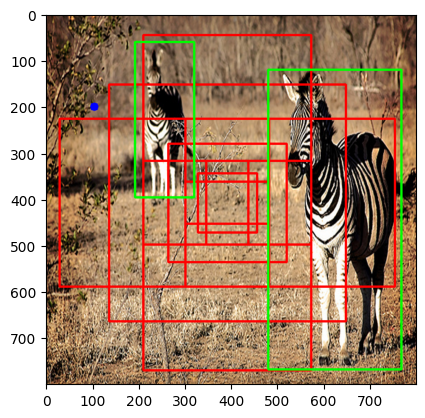

In [16]:
# visualize anchor boxs at center anchor location
img_ = np.copy(img)
# mid anchor center = 2500/2 = 1250
for i in range(11025, 11034):  # 1250 * 9 = 11025 (9 anchors corresponds to mid anchor center)
    x_min = int(anchor_list[i][0])
    y_min = int(anchor_list[i][1])
    x_max = int(anchor_list[i][2])
    y_max = int(anchor_list[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)
    
cv2.circle(img_, (int(center_list[312][0]), int(center_list[312][1])), radius=1, color=(0, 0, 255), thickness=15) 

plt.imshow(img_)
plt.show()

# Assign Labels to Each Anchor Box

# Intersection Over Union (IOU)
A way to measure overlap between two regtangular boxes. Popular evaluation metric for object detection since it measures the overlap between the ground truth and box and the predicted bounding box.

We will use IOU to assign labels to each of the anchor boxes. Firstly:

* We will select all the boxes which fall inside the image.
* We will label the anchor box as “1” (contains object) or positive if it has IOU/ overlap greater than equal to 0.7.
* We will label the anchor box as “0” or negative if it has IOU/ overlap smaller than equal to 0.3.
* We will label the anchor box as “-1” otherwise which will be discarded and won’t be used as a label while training.
* We will also discard all the boxes which are going beyond the image size (outside the image).


Secondly:

* We will assign each anchor box to the ground truth box, which means we will assign what “ground truth” label does anchor box with maximum overlap. For instance, there might be multiple objects in an image, so we assign a ground truth label to the anchor box denoting what ground truth box current anchor box belongs to.

Thirdly:

* We will assign each ground truth box to an anchor box that has maximum IOU.

In [ ]:
def IOU(box1, box2):
    """
    Compute overlap (IOU) between box1 and box2
    """
    
    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    
    # take min of x2 and y2 out of both boxes
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0
    
    # ------computing union------
    # sum of area of both the boxes - area_overlap
    
    # height and width of both boxes
    width_box1 = (box1[2] - box1[0])
    height_box1 = (box1[3] - box1[1])
    
    width_box2 = (box2[2] - box2[0])
    height_box2 = (box2[3] - box2[1])
    
    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2
    
    # union
    area_union = area_union_overlap - area_overlap
    
    # compute IOU
    iou = area_overlap/ area_union
    
    return iou

In [18]:
inside_anchor_list

NameError: name 'inside_anchor_list' is not defined

In [ ]:
iou_list = np.zeros((n_inside_anchor, n_object))

# for each ground truth box ( we have tw in )
for gt_idx, gt_box in enumerate(bbox_list):
    # for each anchor boxes
    for anchor_idx, anchor_box in enumerate(inside_anchor_list):
        # compute IOU
        iou_list[anchor_idx][gt_idx] = IOU(gt_box, anchor_box)
        break